In [1]:
!rm -r /content/sample_data # i hate a lot this folder
path = 'https://drive.google.com/file/d/1jNZz6-e1zgRmGYr1hvF-KgnMDv3L6qIC/view?usp=sharing'
link = path.split('/')
download = f'https://drive.google.com/uc?id={link[-2]}'
!gdown '{download}'

Downloading...
From: https://drive.google.com/uc?id=1jNZz6-e1zgRmGYr1hvF-KgnMDv3L6qIC
To: /content/flowersDS.zip
100% 229M/229M [00:04<00:00, 53.2MB/s]


In [2]:
%%capture
!unzip flowersDS.zip

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [4]:
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms as T # for simplifying the transforms
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split
from torchvision import models
print(torch. __version__)

1.12.1+cu113


In [5]:
## Now, we import timm, torchvision image models
%%capture
!pip install timm # kaggle doesnt have it installed by default
import timm
from timm.loss import LabelSmoothingCrossEntropy # This is better than normal nn.CrossEntropyLoss

In [ ]:
# remove warnings
import warnings
warnings.filterwarnings("ignore")

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
import sys
from tqdm import tqdm
import time
import copy

In [8]:
def get_classes(data_dir):
    all_data = datasets.ImageFolder(data_dir)
    return all_data.classes

In [9]:
def get_data_loaders(data_dir, batch_size, train = False):
    if train:
        #train
        transform = T.Compose([
            T.RandomHorizontalFlip(),
            T.RandomVerticalFlip(),
            T.RandomApply(torch.nn.ModuleList([T.ColorJitter()]), p=0.25),
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # imagenet means
            T.RandomErasing(p=0.2, value='random')
        ])
        train_data = datasets.ImageFolder(os.path.join(data_dir, "train/"), transform = transform)
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return train_loader, len(train_data)
    else:
        # val/test
        transform = T.Compose([ # We dont need augmentation for test transforms
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # imagenet means
        ])
        val_data = datasets.ImageFolder(os.path.join(data_dir, "valid/"), transform=transform)
        test_data = datasets.ImageFolder(os.path.join(data_dir, "test/"), transform=transform)
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=4)
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return val_loader, test_loader, len(val_data), len(test_data)

In [10]:
dataset_path = "./flowers/data/"

In [11]:
(train_loader, train_data_len) = get_data_loaders(dataset_path, 128, train=True)
(val_loader, test_loader, valid_data_len, test_data_len) = get_data_loaders(dataset_path, 32, train=False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [12]:
classes = get_classes("./flowers/data/train/")
print(classes, len(classes))

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'] 5


In [13]:
dataloaders = {
    "train": train_loader,
    "val": val_loader
}
dataset_sizes = {
    "train": train_data_len,
    "val": valid_data_len
}

In [14]:
print(len(train_loader), len(val_loader), len(test_loader))

23 12 12


In [15]:
print(train_data_len, valid_data_len, test_data_len)

2934 367 369


In [16]:
# now, for the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Para cargar el modelo uso el código proporcionado por: [Survey attention medical imaging](https://github.com/TiagoFilipeSousaGoncalves/survey-attention-medical-imaging/blob/main/README.md)

In [17]:
!git clone https://github.com/TiagoFilipeSousaGoncalves/survey-attention-medical-imaging.git

Cloning into 'survey-attention-medical-imaging'...
remote: Enumerating objects: 1971, done.
remote: Counting objects: 100% (85/85), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 1971 (delta 43), reused 46 (delta 21), pack-reused 1886
Receiving objects: 100% (1971/1971), 728.30 KiB | 22.07 MiB/s, done.
Resolving deltas: 100% (1381/1381), done.


In [18]:
%cd survey-attention-medical-imaging

/content/survey-attention-medical-imaging


In [19]:
# Imports
import os
import argparse
import numpy as np
from tqdm import tqdm
import datetime
#from torchinfo import summary

# Sklearn Imports
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

# PyTorch Imports
import torch
from torch.utils.data import DataLoader
import torchvision
from torch.utils.tensorboard import SummaryWriter

In [20]:
%%capture
!pip install transformers==4.17.0
!pip install einops==0.4.1

In [21]:
%cd code

/content/survey-attention-medical-imaging/code


In [22]:
#from transformers import DeiTFeatureExtractor
from transformer_explainability_utils.ViT_LRP import deit_tiny_patch16_224 as DeiT_Tiny

In [23]:
# Input Data Dimensions
img_nr_channels = 3
img_height = 224
img_width = 224
# Number of classes for models
nr_classes =5
IMG_SIZE = 224

model = DeiT_Tiny(pretrained=True, num_classes=nr_classes, input_size=(3, IMG_SIZE, IMG_SIZE), url="https://dl.fbaipublicfiles.com/deit/deit_tiny_patch16_224-a1311bcf.pth")
#feature_extractor = DeiTFeatureExtractor.from_pretrained("facebook/deit-tiny-patch16-224")

Downloading: "https://dl.fbaipublicfiles.com/deit/deit_tiny_patch16_224-a1311bcf.pth" to /root/.cache/torch/hub/checkpoints/deit_tiny_patch16_224-a1311bcf.pth


Model loaded with success.


In [24]:
model.eval

<bound method Module.eval of VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
  )
  (blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (matmul1): einsum()
        (matmul2): einsum()
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
        (softmax): Softmax(dim=-1)
      )
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU(approximate=none)
        (fc2): Linear(in_features=768, out_features=192, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (add1): Add()
      (add2): Add()
      (clone1): Clone()
  

Ahora realizaremos el entrenaminento, regresamos a la raiz: `/content`

In [25]:
model = model.to(device)

In [26]:
%cd /content

/content


In [27]:
criterion = LabelSmoothingCrossEntropy()
criterion = criterion.to(device)
optimizer = optim.Adam(model.head.parameters(), lr=0.001)

In [28]:
# lr scheduler
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)

In [31]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print("-"*10)
        
        for phase in ['train', 'val']: # We do training and validation phase per epoch
            if phase == 'train':
                model.train() # model to training mode
            else:
                model.eval() # model to evaluate
            
            running_loss = 0.0
            running_corrects = 0.0
            
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'): # no autograd makes validation go faster
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1) # used for accuracy
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step() # step at end of epoch
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc =  running_corrects.double() / dataset_sizes[phase]
            
            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict()) # keep the best validation accuracy model
        print()
    time_elapsed = time.time() - since # slight error
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print("Best Val Acc: {:.4f}".format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model

In [32]:
model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler) # now it is a lot faster

Epoch 0/19
----------


100%|██████████| 23/23 [00:16<00:00,  1.37it/s]


train Loss: 0.8073 Acc: 0.8255


100%|██████████| 12/12 [00:02<00:00,  5.78it/s]


val Loss: 0.7628 Acc: 0.8311

Epoch 1/19
----------


100%|██████████| 23/23 [00:16<00:00,  1.43it/s]


train Loss: 0.7453 Acc: 0.8480


100%|██████████| 12/12 [00:02<00:00,  5.90it/s]


val Loss: 0.7299 Acc: 0.8610

Epoch 2/19
----------


100%|██████████| 23/23 [00:16<00:00,  1.42it/s]


train Loss: 0.7153 Acc: 0.8630


100%|██████████| 12/12 [00:02<00:00,  5.61it/s]


val Loss: 0.7125 Acc: 0.8719

Epoch 3/19
----------


100%|██████████| 23/23 [00:16<00:00,  1.41it/s]


train Loss: 0.6978 Acc: 0.8725


100%|██████████| 12/12 [00:02<00:00,  5.69it/s]


val Loss: 0.7000 Acc: 0.8747

Epoch 4/19
----------


100%|██████████| 23/23 [00:17<00:00,  1.29it/s]


train Loss: 0.6834 Acc: 0.8787


100%|██████████| 12/12 [00:02<00:00,  5.75it/s]


val Loss: 0.6898 Acc: 0.8856

Epoch 5/19
----------


100%|██████████| 23/23 [00:16<00:00,  1.40it/s]


train Loss: 0.6719 Acc: 0.8824


100%|██████████| 12/12 [00:02<00:00,  5.77it/s]


val Loss: 0.6834 Acc: 0.8883

Epoch 6/19
----------


100%|██████████| 23/23 [00:19<00:00,  1.20it/s]


train Loss: 0.6621 Acc: 0.8981


100%|██████████| 12/12 [00:02<00:00,  5.53it/s]


val Loss: 0.6781 Acc: 0.8883

Epoch 7/19
----------


100%|██████████| 23/23 [00:17<00:00,  1.32it/s]


train Loss: 0.6537 Acc: 0.9018


100%|██████████| 12/12 [00:02<00:00,  5.70it/s]


val Loss: 0.6728 Acc: 0.8856

Epoch 8/19
----------


100%|██████████| 23/23 [00:17<00:00,  1.28it/s]


train Loss: 0.6519 Acc: 0.8957


100%|██████████| 12/12 [00:02<00:00,  5.09it/s]


val Loss: 0.6703 Acc: 0.8828

Epoch 9/19
----------


100%|██████████| 23/23 [00:17<00:00,  1.32it/s]


train Loss: 0.6478 Acc: 0.8960


100%|██████████| 12/12 [00:02<00:00,  5.83it/s]


val Loss: 0.6701 Acc: 0.8856

Epoch 10/19
----------


100%|██████████| 23/23 [00:17<00:00,  1.32it/s]


train Loss: 0.6416 Acc: 0.9005


100%|██████████| 12/12 [00:02<00:00,  5.58it/s]


val Loss: 0.6697 Acc: 0.8856

Epoch 11/19
----------


100%|██████████| 23/23 [00:17<00:00,  1.31it/s]


train Loss: 0.6414 Acc: 0.9035


100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


val Loss: 0.6690 Acc: 0.8801

Epoch 12/19
----------


100%|██████████| 23/23 [00:17<00:00,  1.33it/s]


train Loss: 0.6357 Acc: 0.9127


100%|██████████| 12/12 [00:02<00:00,  4.83it/s]


val Loss: 0.6687 Acc: 0.8856

Epoch 13/19
----------


100%|██████████| 23/23 [00:18<00:00,  1.27it/s]


train Loss: 0.6413 Acc: 0.9049


100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


val Loss: 0.6678 Acc: 0.8801

Epoch 14/19
----------


100%|██████████| 23/23 [00:16<00:00,  1.38it/s]


train Loss: 0.6322 Acc: 0.9059


100%|██████████| 12/12 [00:02<00:00,  5.76it/s]


val Loss: 0.6677 Acc: 0.8774

Epoch 15/19
----------


100%|██████████| 23/23 [00:16<00:00,  1.37it/s]


train Loss: 0.6351 Acc: 0.9087


100%|██████████| 12/12 [00:02<00:00,  5.67it/s]


val Loss: 0.6659 Acc: 0.8774

Epoch 16/19
----------


100%|██████████| 23/23 [00:16<00:00,  1.37it/s]


train Loss: 0.6270 Acc: 0.9141


100%|██████████| 12/12 [00:02<00:00,  5.70it/s]


val Loss: 0.6642 Acc: 0.8774

Epoch 17/19
----------


100%|██████████| 23/23 [00:16<00:00,  1.36it/s]


train Loss: 0.6285 Acc: 0.9046


100%|██████████| 12/12 [00:02<00:00,  5.77it/s]


val Loss: 0.6635 Acc: 0.8747

Epoch 18/19
----------


100%|██████████| 23/23 [00:17<00:00,  1.29it/s]


train Loss: 0.6251 Acc: 0.9104


100%|██████████| 12/12 [00:02<00:00,  5.66it/s]


val Loss: 0.6625 Acc: 0.8774

Epoch 19/19
----------


100%|██████████| 23/23 [00:16<00:00,  1.38it/s]


train Loss: 0.6249 Acc: 0.9141


100%|██████████| 12/12 [00:02<00:00,  5.67it/s]

val Loss: 0.6637 Acc: 0.8747

Training complete in 6m 28s
Best Val Acc: 0.8883


In [33]:
test_loss = 0.0
class_correct = list(0 for i in range(len(classes)))
class_total = list(0 for i in range(len(classes)))
model.eval()

for data, target in tqdm(test_loader):
    data, target = data.to(device), target.to(device)
    with torch.no_grad(): # turn off autograd for faster testing
        output = model(data)
        loss = criterion(output, target)
    test_loss = loss.item() * data.size(0)
    _, pred = torch.max(output, 1)
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    if len(target) == 32:
        for i in range(32):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

test_loss = test_loss / test_data_len
print('Test Loss: {:.4f}'.format(test_loss))
for i in range(len(classes)):
    if class_total[i] > 0:
        print("Test Accuracy of %5s: %2d%% (%2d/%2d)" % (
            classes[i], 100*class_correct[i]/class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])
        ))
    else:
        print("Test accuracy of %5s: NA" % (classes[i]))
print("Test Accuracy of %2d%% (%2d/%2d)" % (
            100*np.sum(class_correct)/np.sum(class_total), np.sum(class_correct), np.sum(class_total)
        ))

100%|██████████| 12/12 [00:02<00:00,  5.53it/s]

Test Loss: 0.0273
Test Accuracy of daisy: 93% (56/60)
Test Accuracy of dandelion: 90% (79/87)
Test Accuracy of roses: 85% (52/61)
Test Accuracy of sunflowers: 86% (60/69)
Test Accuracy of tulips: 90% (68/75)
Test Accuracy of 89% (315/352)


10 epocas:

Test Accuracy of daisy: 95% (60/63)\
Test Accuracy of dandelion: 91% (79/86)\
Test Accuracy of roses: 78% (48/61)\
Test Accuracy of sunflowers: 86% (57/66)\
Test Accuracy of tulips: 88% (67/76)\
Test Accuracy of 88% (311/352)\

15 epocas:

Test Accuracy of daisy: 90% (58/64)\
Test Accuracy of dandelion: 96% (78/81)\
Test Accuracy of roses: 81% (49/60)\
Test Accuracy of sunflowers: 91% (62/68)\
Test Accuracy of tulips: 93% (74/79)\
Test Accuracy of 91% (321/352)\

20 epocas:

Test Accuracy of daisy: 93% (56/60)\
Test Accuracy of dandelion: 90% (79/87)\
Test Accuracy of roses: 85% (52/61)\
Test Accuracy of sunflowers: 86% (60/69)\
Test Accuracy of tulips: 90% (68/75)\
Test Accuracy of 89% (315/352)\


Usamos [Transformer Explainability](https://github.com/hila-chefer/Transformer-Explainability.git)  para visualizar los mapas de atención.

In [34]:
!git clone https://github.com/hila-chefer/Transformer-Explainability.git

Cloning into 'Transformer-Explainability'...
remote: Enumerating objects: 377, done.
remote: Counting objects: 100% (152/152), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 377 (delta 127), reused 74 (delta 74), pack-reused 225
Receiving objects: 100% (377/377), 3.83 MiB | 4.28 MiB/s, done.
Resolving deltas: 100% (190/190), done.


In [35]:
%cd '/content/Transformer-Explainability'

/content/Transformer-Explainability


In [ ]:
#import os
#os.chdir(f'./Transformer-Explainability')

In [36]:
from baselines.ViT.ViT_explanation_generator import LRP

In [37]:
attribution_generator = LRP(model)

In [38]:
import sys
from torchvision import transforms
from PIL import Image
import numpy
import numpy as np
import matplotlib.pyplot as plt
import cv2

normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize,
])

In [39]:
# create heatmap from mask on image
def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return cam

def show_cam_on_image_plus(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    #cam = heatmap + np.float32(img)
    cam = heatmap
    cam = cam / np.max(cam)
    return cam
    
def generate_visualization_plus(original_image, class_index=None , plus=False):
    transformer_attribution = attribution_generator.generate_LRP(original_image.unsqueeze(0).cuda(), method="transformer_attribution", index=class_index).detach()
    transformer_attribution = transformer_attribution.reshape(1, 1, 14, 14)
    transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')
    transformer_attribution = transformer_attribution.reshape(224, 224).cuda().data.cpu().numpy()
    transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())
    image_transformer_attribution = original_image.permute(1, 2, 0).data.cpu().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    if plus:
      vis = show_cam_on_image_plus(image_transformer_attribution, transformer_attribution)
    else:
      vis = show_cam_on_image(image_transformer_attribution, transformer_attribution)
    vis =  np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis

def print_top_classes(predictions, **kwargs):    
    # Print Top-5 predictions
    prob = torch.softmax(predictions, dim=1)
    class_indices = predictions.data.topk(5, dim=1)[1][0].tolist()
    max_str_len = 0
    class_names = []
    for cls_idx in class_indices:
        class_names.append(CLS2IDX[cls_idx])
        if len(CLS2IDX[cls_idx]) > max_str_len:
            max_str_len = len(CLS2IDX[cls_idx])
    
    print('Top 5 classes:')
    for cls_idx in class_indices:
        output_string = '\t{} : {}'.format(cls_idx, CLS2IDX[cls_idx])
        output_string += ' ' * (max_str_len - len(CLS2IDX[cls_idx])) + '\t\t'
        output_string += 'value = {:.3f}\t prob = {:.1f}%'.format(predictions[0, cls_idx], 100 * prob[0, cls_idx])
        print(output_string)

In [40]:
imagesToDownload = {0: 'https://images.hola.com/imagenes/decoracion/20211013197604/cultivar-tulipanes-plantas-interior-exterior-il/1-6-257/cultivar-tulipanes-04a-a.jpg',
                    1: 'https://elarbol.org/wp-content/uploads/2018/09/word-image-116.jpeg',
                    2: 'https://assets.simpleviewinc.com/simpleview/image/upload/c_limit,h_1200,q_75,w_1200/v1/clients/raleigh/tim_bish_qdccZLaqKOs_unsplash_b8846269-b9dd-4349-b4f0-031e9775442a.jpg',
                    3: 'https://www.jardineriaon.com/wp-content/uploads/2015/10/rosa-te.jpg',
                    4: 'https://st2.depositphotos.com/1001085/5877/i/450/depositphotos_58775193-stock-photo-single-white-rose-isolated-on.jpg',
                    5: 'https://cdn.shopify.com/s/files/1/0488/7855/1202/products/meadow-daisy-seed-s869_3d4d3380-4b8c-4f35-b730-02060660d800_1200x.jpg',
                    6: 'https://britishlocalfood.com/wp-content/uploads/img-dir/dandelion-foraging-1.jpg',
                    7: 'https://images.immediate.co.uk/production/volatile/sites/10/2018/08/2048x1365-Red-tulips-LI2098086-ecb2867.jpg',
                    8: 'https://i.pinimg.com/originals/4c/c7/d7/4cc7d75430296c8b175a3be193e93b2c.jpg',
                    9: 'https://assets.puzzlefactory.pl/puzzle/201/389/original.jpg',
                    10:'https://cdn.shopify.com/s/files/1/2652/9998/products/Delight2021_1024x1024_2x_96f05c35-f204-4f94-9526-ccc10e0e1a8d.png?v=1631543828',                                  
                    11:'https://s3-media0.fl.yelpcdn.com/bphoto/Hr3S2dlUCV8ocT3K402fNg/348s.jpg',
                    12:'https://thumbs.dreamstime.com/b/sunflowers-red-rose-wedding-bouquet-close-up-closeup-detail-yellow-sunflower-red-rose-wedding-flower-arrangement-139595503.jpg',
                    }

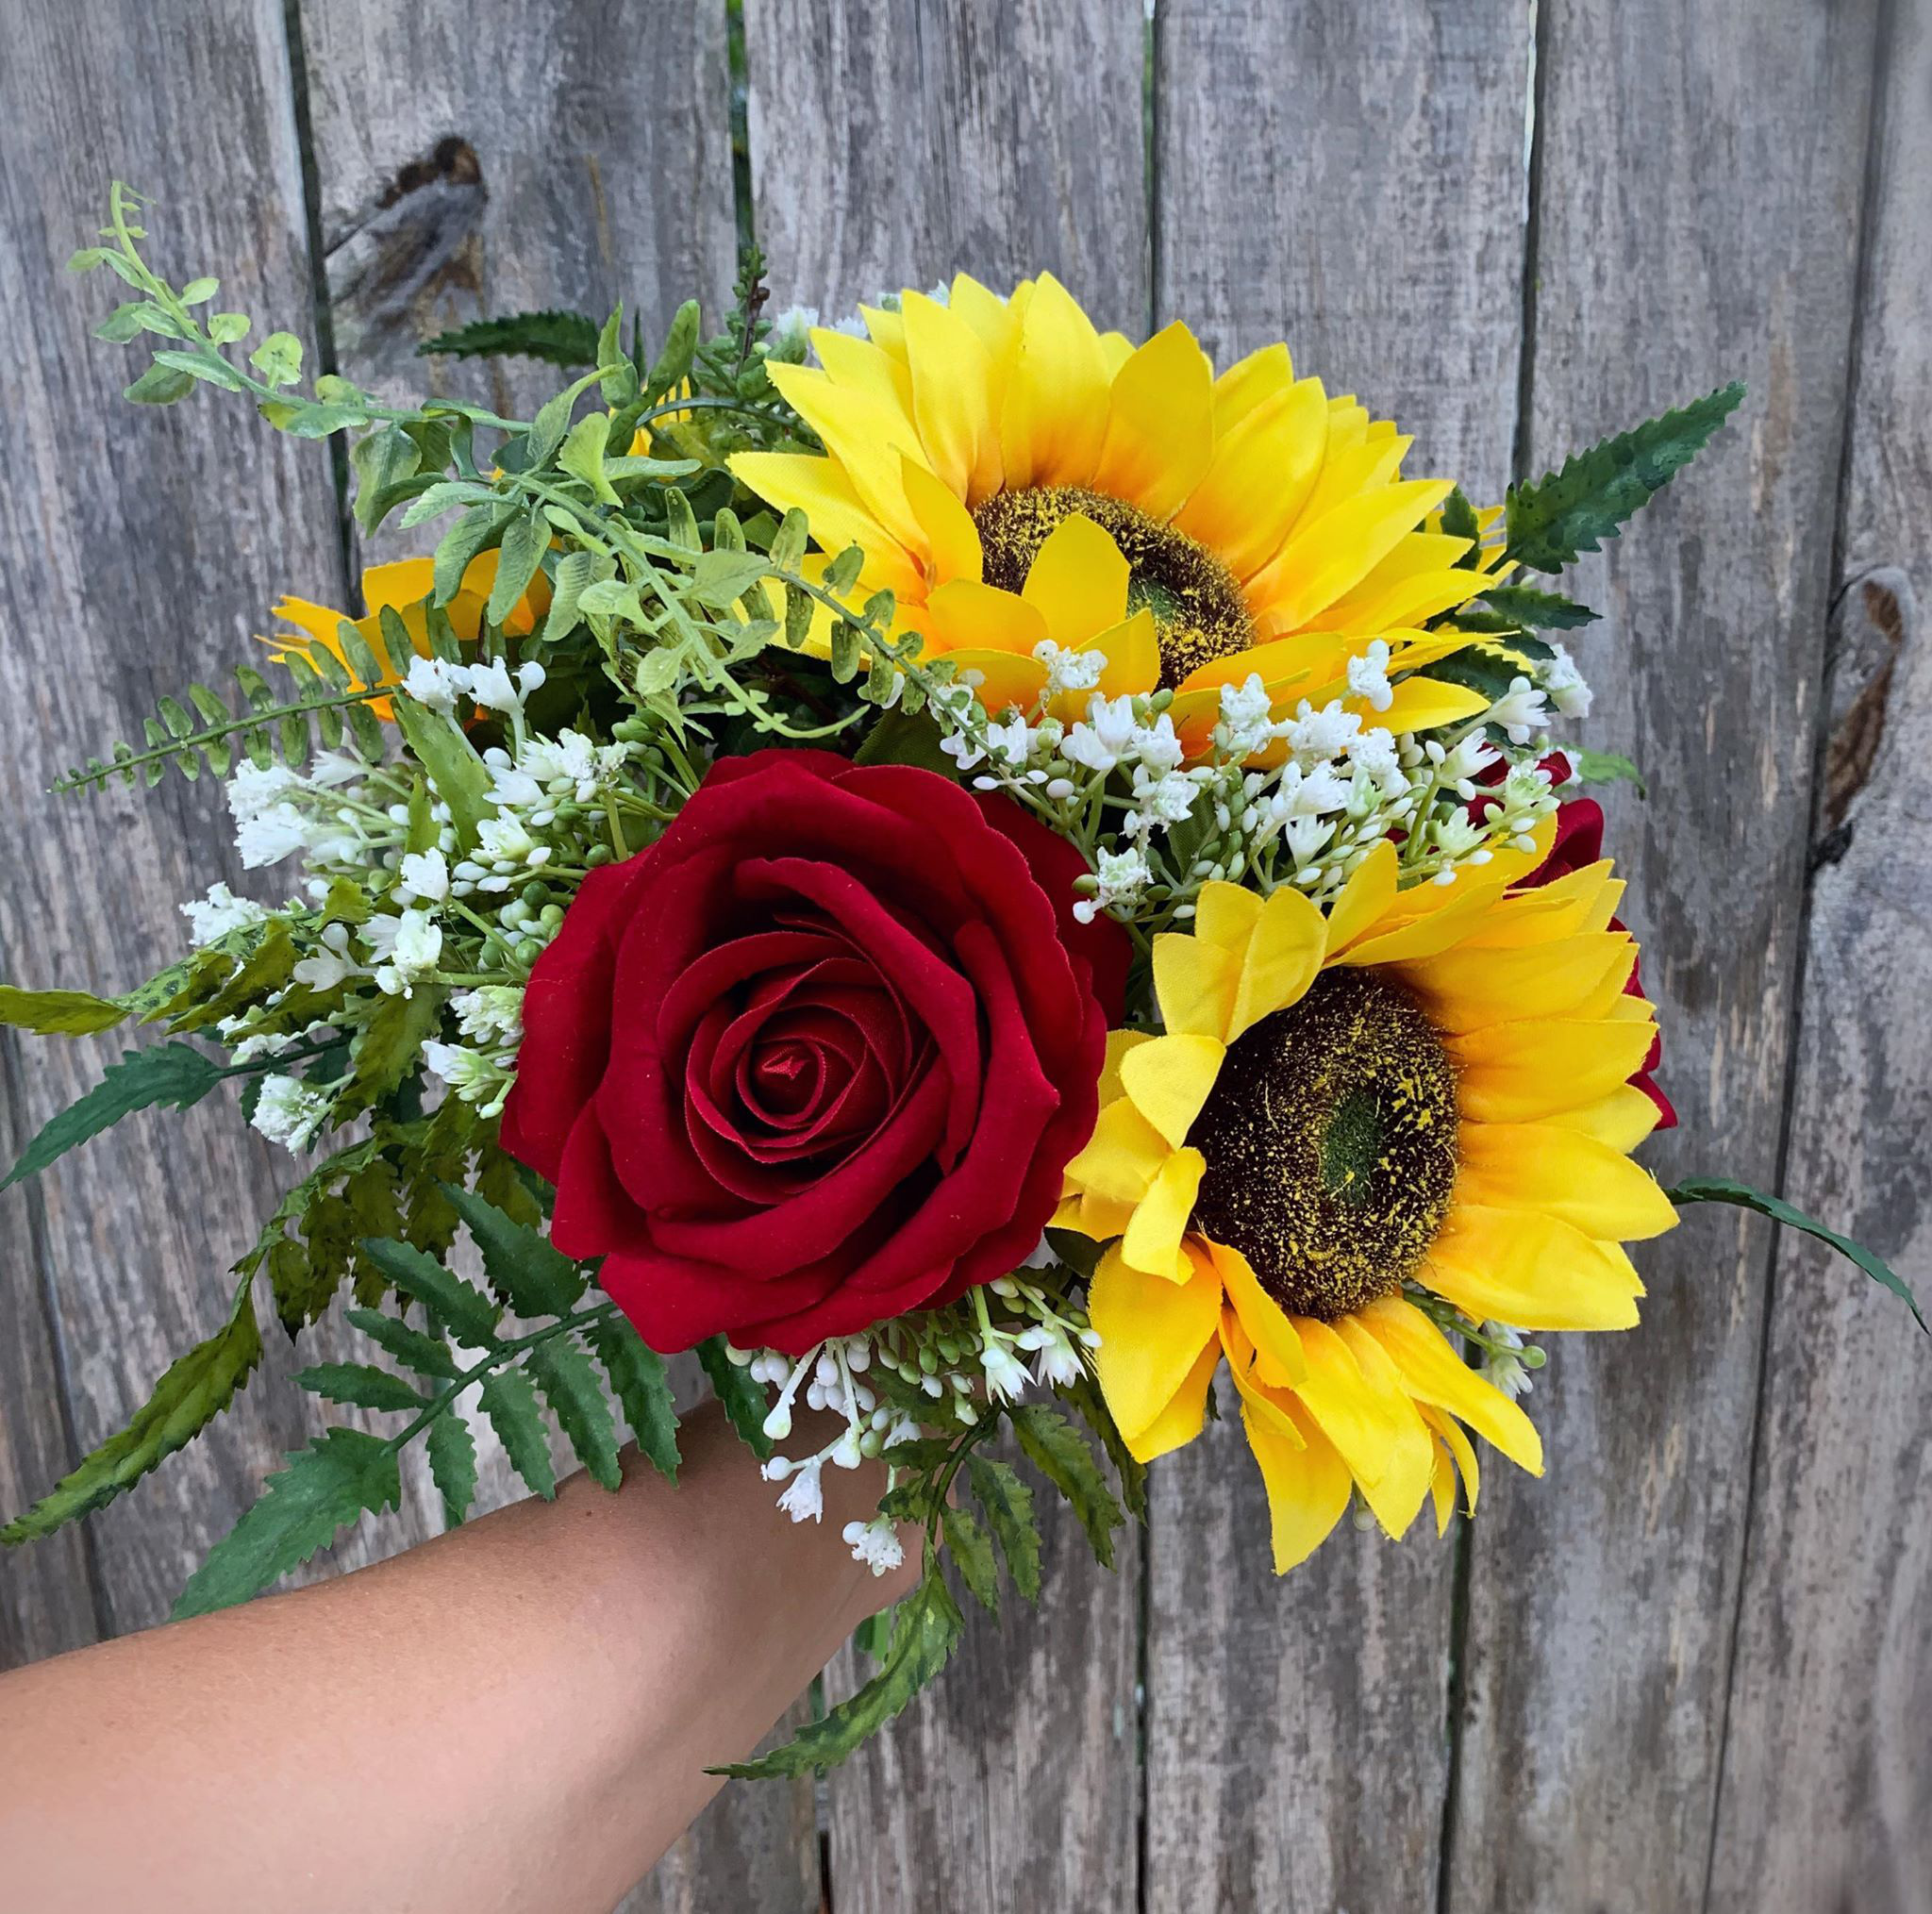

In [41]:
#@title Imágenes a descargar, vea index en `imagesToDownload`:
IndexOffiles = '8' #@param [0,1,2,3,4,5,6,7,8,9,10,11,12] {allow-input: true}
URL = imagesToDownload[int(IndexOffiles)]
import requests
if os.path.exists('image.jpg'):
  os.remove('image.jpg') 
response = requests.get(URL)
open("image.jpg", "wb").write(response.content)
img = Image.open('./image.jpg')
img

In [42]:
CLS2IDX = {0: 'daisy',
 1: 'dandelion',
 2: 'roses',
 3: 'sunflowers',
 4: 'tulips'
}

Top 5 classes:
	2 : roses     		value = 1.033	 prob = 45.2%
	3 : sunflowers		value = 0.776	 prob = 34.9%
	1 : dandelion 		value = -0.734	 prob = 7.7%
	4 : tulips    		value = -0.853	 prob = 6.8%
	0 : daisy     		value = -1.104	 prob = 5.3%


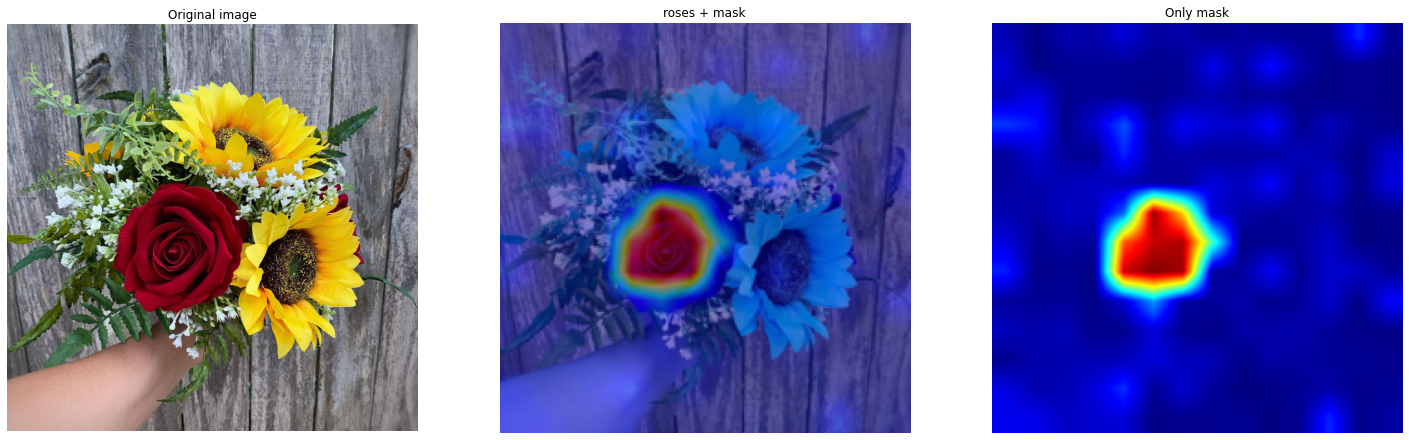

In [44]:
#@title Clases de flores:
chose = 'roses' #@param ["daisy", "dandelion", "roses", "sunflowers", "tulips"]

index = list(CLS2IDX.values()).index(chose)

image = Image.open('image.jpg')
tusker_zebra_image = transform(image)

output = model(tusker_zebra_image.unsqueeze(0).cuda())


fig, axs = plt.subplots(1, 3, figsize=(25, 25))
axs[0].title.set_text('Original image')
axs[0].imshow(image);
axs[0].axis('off');

print_top_classes(output)


# zebra 
# zebra- the predicted class
tulips = generate_visualization_plus(tusker_zebra_image, class_index=index)

# generate visualization for class 101: 'tusker'
tusker = generate_visualization_plus(tusker_zebra_image, class_index=index, plus=True)

axs[1].title.set_text(f'{chose} + mask')
axs[1].imshow(tulips);
axs[1].axis('off');
axs[2].imshow(tusker);
axs[2].title.set_text('Only mask')
axs[2].axis('off');